## Debugging playground

developing bellini

In [1]:
from bellini.groups import *
from bellini.quantity import Quantity
from bellini.distributions import Normal
from bellini.units import *
import networkx as nx
import pprint

In [2]:
sugar = Species(name="sugar")
water = Species(name="water")

one_mol_sugar = Substance(sugar, Quantity(1.0, ureg.mole))
ten_ml_water = Solvent(water, Quantity(10.0, ureg.milliliter))
water_stock = Solvent(water, Quantity(100.0, ureg.milliliter))
sugar_water = Solution(one_mol_sugar, ten_ml_water)

In [15]:
sugar_stock_bottle = Well(solution = sugar_water)

water_stock_bottle = Well(solution = water_stock)

plate = [Well() for i in range(3)]

from bellini.actions import *
pipette = Dispenser("pipette", Quantity(0.1, ureg.milliliter))

pipette.apply(sugar_stock_bottle, plate[0], Quantity(5.0, ureg.milliliter))
print(plate[0].observe('moles'), plate[0].observe('volume'))
pipette.apply(water_stock_bottle, plate[0], Quantity(5.0, ureg.milliliter))
print(plate[0].observe('moles'), plate[0].observe('volume'))
plate[0].observe('moles').trace = True
plate[0].observe('volume').trace = True
pipette.apply(plate[0], plate[1], Quantity(5.0, ureg.milliliter))
print(plate[0].observe('moles'), plate[0].observe('volume'))
pipette.apply(water_stock_bottle, plate[1], Quantity(5.0, ureg.milliliter))
print(plate[0].observe('moles'), plate[0].observe('volume'))

CompDist w mag 0.50 mol N(5.00 ml, 0.01 ml ** 2)
CompDist w mag 0.50 mol CompDist w mag 10.00 ml
CompDist w mag 0.25 mol CompDist w mag 5.00 ml
CompDist w mag 0.25 mol CompDist w mag 5.00 ml


In [16]:
plate[1].observe('concentration').units

<Unit('mole / milliliter')>

In [17]:
plate[0].observe('moles').trace = True
plate[0].observe('volume').trace = True

In [18]:
conc_measure = Measurer("uv_vis", Quantity(0.1, ureg.mole / ureg.milliliter))
concentration = conc_measure.apply(plate[1], value="concentration")

In [19]:
plate[0].observe('moles') in concentration.g.nodes()

False

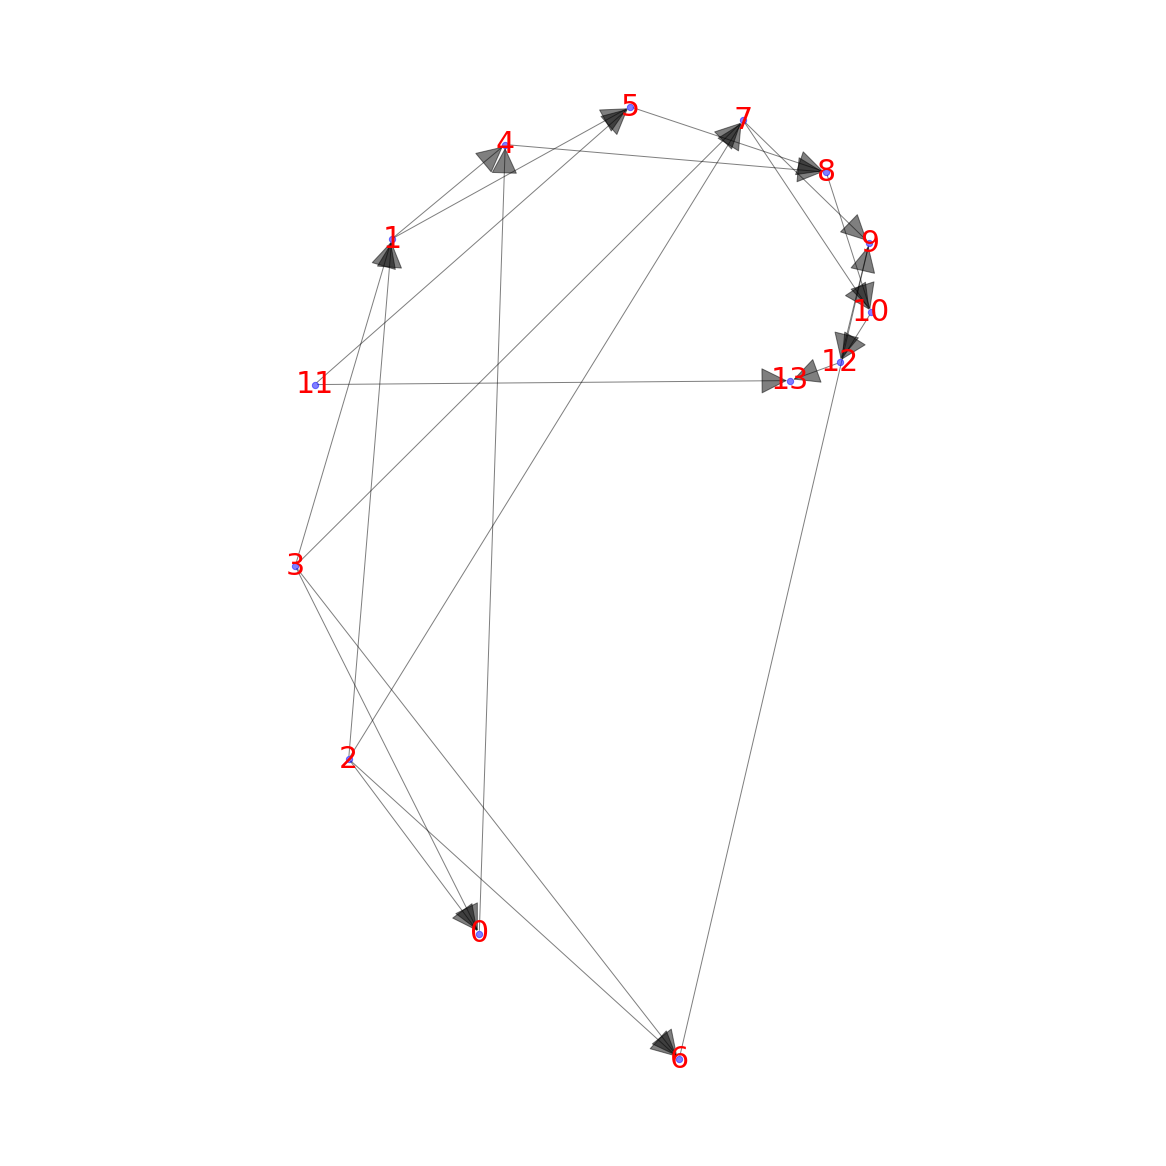

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

# This example needs Graphviz and either PyGraphviz or pydot
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

G = concentration.g

labels = {}    

observed_nodes = [node for node in G.nodes if hasattr(node, "observed")]
observed_nodes = [node for node in observed_nodes if node.observed is True]
observed_node = observed_nodes[0]
edges = list(nx.bfs_edges(G, source=observed_node, reverse=True))[::-1]
nodes = [edge[1] for edge in edges] + [observed_node]

for node in G.nodes():
    labels[node] = nodes.index(node)

pos = nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=False, arrowsize=60)
nx.draw_networkx_labels(G,pos,labels, font_color='r', font_size='30')
plt.axis("equal")
plt.show()

In [21]:
nx.is_directed_acyclic_graph(concentration.g)

True

In [22]:
from bellini.api._numpyro import graph_to_numpyro_model
import numpyro 

model = graph_to_numpyro_model(concentration.g)
with numpyro.handlers.seed(rng_seed=0):
    out, model_dict = model()
    print(model_dict)


{<Quantity(5.0, 'milliliter')>: <Quantity(5.0, 'milliliter')>, <Quantity(0.1, 'milliliter')>: <Quantity(0.1, 'milliliter')>, N(5.00 ml, 0.01 ml ** 2): <Quantity(4.8748459815979, 'milliliter')>, <Quantity(0.1, 'mole / milliliter')>: <Quantity(0.1, 'mole / milliliter')>, CompDist w mag 0.50 mol: <Quantity(0.4874846041202545, 'mole')>, N(5.00 ml, 0.01 ml ** 2): <Quantity(4.9413347244262695, 'milliliter')>, CompDist w mag 10.00 ml: <Quantity(9.816181182861328, 'milliliter')>, CompDist w mag 0.05 mol/ml: <Quantity(0.04966133087873459, 'mole / milliliter')>, N(5.00 ml, 0.01 ml ** 2): <Quantity(5.048648357391357, 'milliliter')>, CompDist w mag 0.25 mol: <Quantity(0.25072258710861206, 'mole')>, N(5.00 ml, 0.01 ml ** 2): <Quantity(5.021714210510254, 'milliliter')>, CompDist w mag 10.00 ml: <Quantity(10.070362091064453, 'milliliter')>, CompDist w mag 0.03 mol/ml: <Quantity(0.024897078052163124, 'mole / milliliter')>, N(CompDist w mag 0.03 mol/ml, 0.01 mol ** 2 / ml ** 2): <Quantity(-0.0399662703

In [23]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

niter = 500000  # number of iterations
nburn = 50000  # number of burn-in iterations to discard
nthin = 500  # thinning interval

class MCMCModel:
    def __init__(
        self,
        model,
        kernel_args={'step_size':1},
        mcmc_args={"num_warmup": nburn, "num_samples": niter, "thinning": nthin},
    ):
        self.model = model
        self.mcmc = None
        self.kernel_args = kernel_args
        self.mcmc_args = mcmc_args
        self.params = None
        rng_key = random.PRNGKey(0)  # TODO: make option to choose random seed
        self.rng_key_infer, self.rng_key_predict = random.split(rng_key)

    def run_mcmc(self, *args, **kwargs):
        nuts_kernel = NUTS(self.model, **self.kernel_args)
        self.mcmc = MCMC(nuts_kernel, **self.mcmc_args)
        self.mcmc.run(self.rng_key_infer, *args, **kwargs)
        self.sample_params()

    def sample_params(self):
        self.params = self.mcmc.get_samples()

    def predict(self, *args, **kwargs):
        predictor = Predictive(self.model, self.params)
        return predictor(self.rng_key_predict, *args, **kwargs)

    def plot_results(self, exclude_deterministic=False):
        self.mcmc.print_summary(exclude_deterministic=exclude_deterministic)
        data = az.from_numpyro(self.mcmc)
        az.plot_trace(data)

In [24]:
def model_wrapper(obs = None):
    return model(obs = obs)[0]


In [25]:
mcmc_wrapper = MCMCModel(model_wrapper, mcmc_args={"num_warmup": 10000, "num_samples": 20000, "thinning": 1})
#mcmc_wrapper.run_mcmc(obs = Quantity(0.05, ureg.mole / ureg.milliliter))
mcmc_wrapper.run_mcmc(obs = 0.05)
#mcmc_wrapper.run_mcmc()


sample: 100%|██████████| 30000/30000 [00:22<00:00, 1326.80it/s, 7 steps of size 8.92e-01. acc. prob=0.88] 



                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                  CompDist w mag 0.50 mol      0.50      0.01      0.50      0.48      0.52  23549.17      1.00
                  CompDist w mag 10.00 ml     10.00      0.14     10.00      9.77     10.24  24686.52      1.00
  vol_transfer_N(5.00 ml, 0.01 ml ** 2)_0      5.00      0.10      5.00      4.84      5.17  23549.17      1.00
  vol_transfer_N(5.00 ml, 0.01 ml ** 2)_1      5.00      0.10      5.00      4.84      5.17  24632.04      1.00
  vol_transfer_N(5.00 ml, 0.01 ml ** 2)_2      5.00      0.10      5.00      4.84      5.17  25382.84      1.00
  vol_transfer_N(5.00 ml, 0.01 ml ** 2)_3      5.00      0.10      5.00      4.83      5.16  24951.26      1.00

Number of divergences: 0


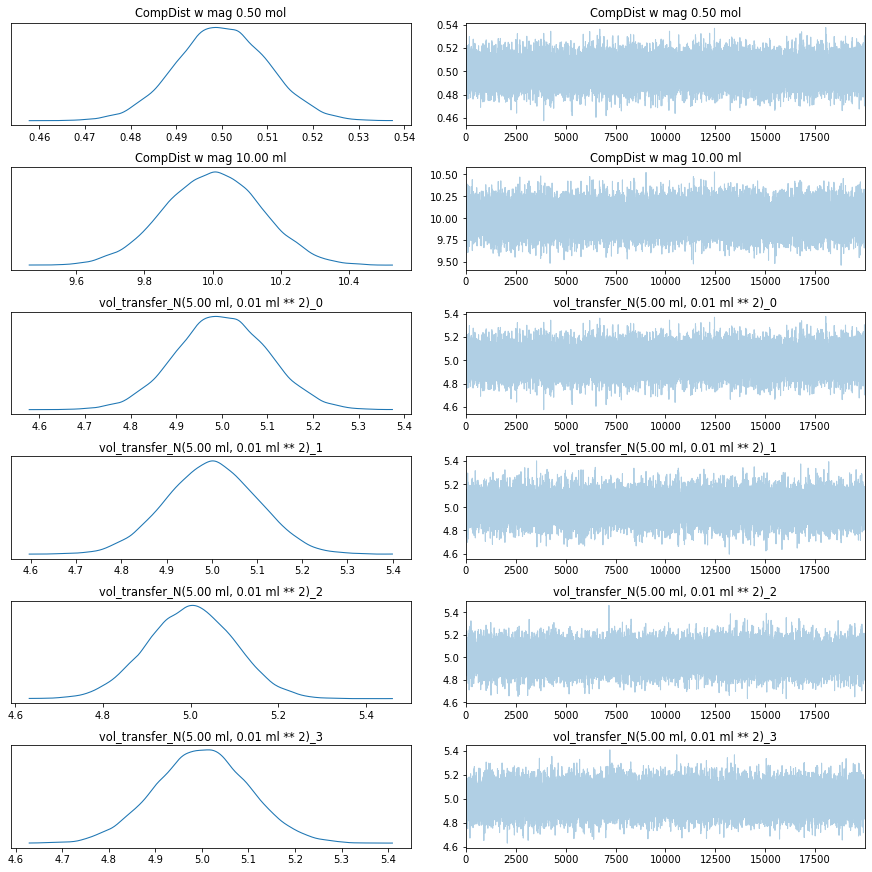

In [26]:
mcmc_wrapper.plot_results()